<a href="https://colab.research.google.com/github/Jumabek/net_intrusion_detection/blob/transformer/Comparing_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown --id 1-t3RdDpmqMs4ABt9oobSapeNYTZJ9tpu
!unzip MachineLearningCSV.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1-t3RdDpmqMs4ABt9oobSapeNYTZJ9tpu
To: /content/MachineLearningCSV.zip
100% 235M/235M [00:00<00:00, 247MB/s]
Archive:  MachineLearningCSV.zip
   creating: MachineLearningCVE/
  inflating: MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv  
  inflating: MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv  
  inflating: MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv  
  inflating: MachineLearningCVE/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv  
  inflating: MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv  
  inflating: MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv  
  inflating: MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv  
  in

In [ ]:
!wget https://raw.githubusercontent.com/Jumabek/net_intrusion_detection/develop/preprocessing.py

--2023-08-06 03:38:46--  https://raw.githubusercontent.com/Jumabek/net_intrusion_detection/develop/preprocessing.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3790 (3.7K) [text/plain]
Saving to: ‘preprocessing.py’

preprocessing.py    100%[===================>]   3.70K  --.-KB/s    in 0s      

2023-08-06 03:38:46 (75.4 MB/s) - ‘preprocessing.py’ saved [3790/3790]



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from preprocessing import load_data, balance_data, normalize
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


In [ ]:
dataroot = 'MachineLearningCVE/'
from preprocessing import read_data
data = read_data(dataroot,'*.pcap_ISCX.csv')

[########################################] | 100% Completed | 29.98 s


In [ ]:
# Load, balance and normalize the data
X, y = load_data(dataroot)
X, y = balance_data(X, y, seed=42)
X = normalize(X)

[########################################] | 100% Completed | 29.63 s
there are 2830743 flow records with 79 feature dimension
stripped column names
dropped bad columns
There are 0 nan entries
converted to numeric


In [ ]:
# Use only 10% of the data
sample_idx = np.random.choice(len(X), int(0.1*len(X)), replace=False)
X = X[sample_idx]
y = y[sample_idx]


In [ ]:
# Splitting the Data
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=64, nhead=8, num_layers=5, dim_feedforward=128, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)  # Add a fake batch dimension for the transformer
        x = self.transformer(x, x)  # Encoder-Decoder Self-Attention
        x = x.squeeze(1)
        x = self.fc(x)
        return x


def evaluate_model(model, data_loader):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for data, labels in data_loader:
            data = data.cuda()
            labels = labels.cuda()

            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')

    return accuracy, f1, precision, recall


In [ ]:
def train_model(num_layers):
    # Dataset and Dataloader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    batch_size = 5120
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Model Configuration
    input_dim = X_train_tensor.shape[1]
    num_classes = len(np.unique(y))
    model = TransformerModel(input_dim, num_classes, num_layers=num_layers)
    model = model.cuda()

    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training Loop
    for epoch in range(10):
        model.train()
        running_loss = 0.0
        for i, (data, labels) in enumerate(train_loader):
            data = data.cuda()
            labels = labels.cuda()

            outputs = model(data)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Layers: {num_layers}, Epoch [{epoch + 1}/10], Loss: {running_loss / len(train_loader)}')
    accuracy, f1, precision, recall = evaluate_model(model, DataLoader(test_dataset, batch_size=batch_size))
    print(f'Layers: {num_layers}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

    return accuracy, f1, precision, recall



In [ ]:
# Lists to store metrics for each model configuration
layers_list = [2, 3, 4, 5, 6]
accuracies = []
f1_scores = []
precisions = []
recalls = []

for layers in layers_list:
    acc, f1, prec, rec = train_model(layers)
    accuracies.append(acc)
    f1_scores.append(f1)
    precisions.append(prec)
    recalls.append(rec)


Layers: 2, Epoch [1/10], Loss: 1.598756661781898
Layers: 2, Epoch [2/10], Loss: 0.7164822908548208
Layers: 2, Epoch [3/10], Loss: 0.48704511920611065
Layers: 2, Epoch [4/10], Loss: 0.37513094147046405
Layers: 2, Epoch [5/10], Loss: 0.3471635442513686
Layers: 2, Epoch [6/10], Loss: 0.30851398140956193
Layers: 2, Epoch [7/10], Loss: 0.2808661781824552
Layers: 2, Epoch [8/10], Loss: 0.2659650093469864
Layers: 2, Epoch [9/10], Loss: 0.2940063147972792
Layers: 2, Epoch [10/10], Loss: 0.25406247950517213
Layers: 2, Accuracy: 0.8830, F1: 0.8784, Precision: 0.8910, Recall: 0.8830
Layers: 3, Epoch [1/10], Loss: 1.701884579964173
Layers: 3, Epoch [2/10], Loss: 0.7019640971452762
Layers: 3, Epoch [3/10], Loss: 0.4799267099453853
Layers: 3, Epoch [4/10], Loss: 0.37222492007108837
Layers: 3, Epoch [5/10], Loss: 0.3317685807362581
Layers: 3, Epoch [6/10], Loss: 0.3026669720808665
Layers: 3, Epoch [7/10], Loss: 0.301386113350208
Layers: 3, Epoch [8/10], Loss: 0.2681795767484567
Layers: 3, Epoch [9/10

In [ ]:
# Provided data
layers_list = [2, 3, 4, 5, 6]
accuracies = [0.8830012717253073, 0.8815175922000847, 0.8938109368376431, 0.892727615279544, 0.8861334840563327]
f1_scores = [0.8784142045161335, 0.8645269833610872, 0.8869040490518022, 0.8789393042658686, 0.8693363664942275]
precisions = [0.891003315227409, 0.917062796794138, 0.9097719647444211, 0.9220944437778784, 0.9189170160778739]
recalls = [0.8830012717253073, 0.8815175922000847, 0.8938109368376431, 0.892727615279544, 0.8861334840563327]

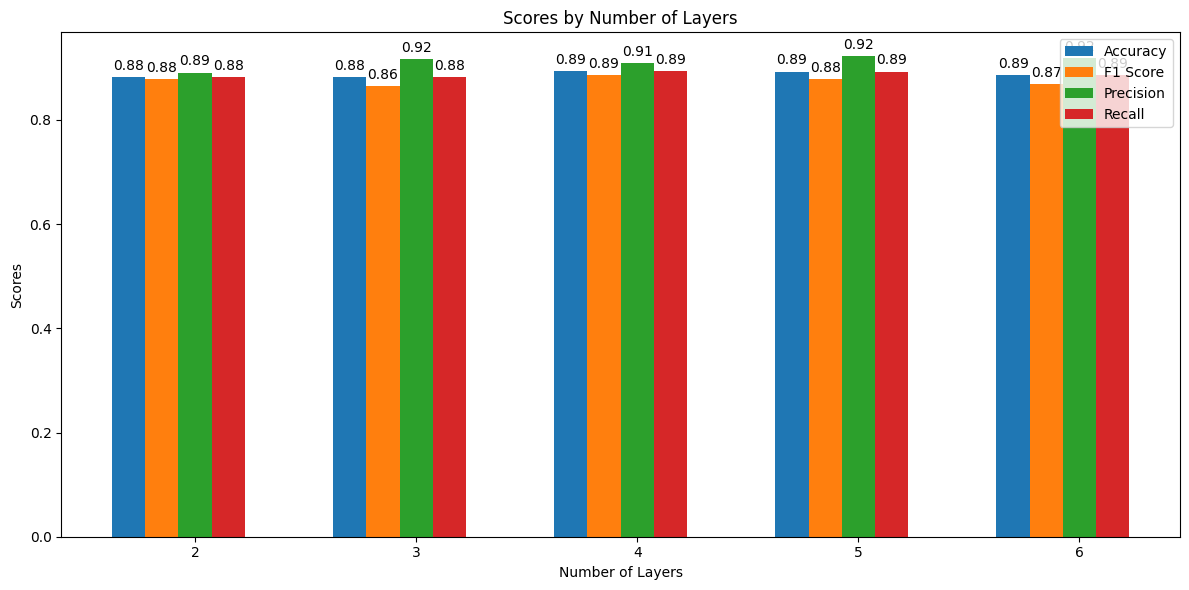

In [ ]:
# Plotting the metrics
import matplotlib.pyplot as plt
import numpy as np

# Create an index for each tick position
x_indexes = np.arange(len(layers_list))
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Generate bar graphs
rects1 = ax.bar(x_indexes - 2 * width, accuracies, width, label='Accuracy')
rects2 = ax.bar(x_indexes - width, f1_scores, width, label='F1 Score')
rects3 = ax.bar(x_indexes, precisions, width, label='Precision')
rects4 = ax.bar(x_indexes + width, recalls, width, label='Recall')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Number of Layers')
ax.set_ylabel('Scores')
ax.set_title('Scores by Number of Layers')
ax.set_xticks(x_indexes)
ax.set_xticklabels(layers_list)
ax.legend()

# Attach a text label above each bar in *rects*, displaying its height
for rects in [rects1, rects2, rects3, rects4]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

fig.tight_layout()

plt.show()


In [ ]:
print("layers_list:", layers_list)
print("accuracies:", accuracies)
print("f1_scores:", f1_scores)
print("precisions:", precisions)
print("recalls:", recalls)

layers_list: [2, 3, 4, 5, 6]
accuracies: [0.8830012717253073, 0.8815175922000847, 0.8938109368376431, 0.892727615279544, 0.8861334840563327]
f1_scores: [0.8784142045161335, 0.8645269833610872, 0.8869040490518022, 0.8789393042658686, 0.8693363664942275]
precisions: [0.891003315227409, 0.917062796794138, 0.9097719647444211, 0.9220944437778784, 0.9189170160778739]
recalls: [0.8830012717253073, 0.8815175922000847, 0.8938109368376431, 0.892727615279544, 0.8861334840563327]
